In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
def list_experiments(variableName="cVeg"):
    exps = set()
    for filename in os.listdir():
        if filename.startswith(variableName):
            #print(filename)
            exps.add(filename.split("_")[2])
    return exps


def load(variableName="cVeg", experiment="CanESM5"):
    experimentfiles = []
    for filename in os.listdir():
        if filename.startswith(variableName) and filename.split("_")[2].lower() == experiment.lower():
            experimentfiles.append(filename)
    
    experimentfiles.sort()
    nplist = []
    
    for filename in experimentfiles:
        arr = xr.open_dataset(filename)[variableName].to_numpy()
        nplist.append(arr)

    final = np.concatenate(nplist)    
    return final    

In [3]:
start_x = 12*(0) # 1850
end_x = 12*(25) # 1875
start_y = 12*(75) # 1925
end_y = 12*(100) # 1950

def avg20(ds):
    return np.mean(ds, axis=0) # axis of mean = time

In [4]:
from sklearn.linear_model import LinearRegression

In [81]:
def plot_and_test(input, output, mask,color=None,ax=plt):
    output = output[mask].flatten()
    input = input[mask].flatten()
    
    ax.scatter(input, output, alpha=0.2, color=color)

# Here Be Dragons...
def fit_and_test(inputs, output, masks, test_inputs, test_output, title=""):
    modelshape = inputs[0].shape

    predicted_present = np.full(modelshape, np.nan)
    predicted_future = np.full(modelshape, np.nan)

    cmip_present = np.full(modelshape, np.nan)
    cmip_future = np.full(modelshape, np.nan)
    
    for mask in masks:
        # Prepare and mask inputs/outputs for linreg
        model_inputs = inputs[:,mask]#.flatten()
        model_test_inputs = test_inputs[:,mask]#.flatten()
        
        model_inputs = np.array(model_inputs).transpose()
        model_test_inputs = np.array(model_test_inputs).transpose()
        
        model_output = output[mask].flatten()
        model_test_output = test_output[mask].flatten()
    
        # Fit and score model
        model = LinearRegression()
        model.fit(model_inputs, model_output)
    
        R2_present = model.score(model_inputs, model_output)
        R2_future = model.score(model_test_inputs, model_test_output)

        print(title, "*", model.coef_, "+", model.intercept_)
        print(title, "R^2 Present", R2_present)
        print(title, "R^2 Future", R2_future) 
        
        predicted_present[mask] = model.predict(model_inputs) 
        predicted_future[mask] = model.predict(model_test_inputs)
    
        cmip_present[mask] = model_output  
        cmip_future[mask] = model_test_output

    # Setup plots
    fig, axs = plt.subplots(2, 3, figsize=(36, 12)) #+ 4 * len(inputs)))
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.tight_layout()
    fig.suptitle(title)
    axs[0][0].set_title("Historical")
    axs[0][1].set_title("Future")
    axs[0][2].set_title("Difference")
    
    axs[0][0].set_ylabel("CMIP")
    axs[0][0].imshow(cmip_present[::-1], vmin=0, vmax=16, interpolation='none', extent=[0,360,-90,90])
    pcm0 = axs[0][1].imshow(cmip_future[::-1], vmin=0, vmax=16, interpolation='none', extent=[0,360,-90,90])

    axs[1][0].set_ylabel("Predicted")
    axs[1][0].imshow(predicted_present[::-1], vmin=0, vmax=16, interpolation='none', extent=[0,360,-90,90])
    pcm1 = axs[1][1].imshow(predicted_future[::-1], vmin=0, vmax=16, interpolation='none', extent=[0,360,-90,90])
    fig.colorbar(pcm1, ax=[axs[0][0], axs[0][1], axs[1][0], axs[1][1]], shrink=0.5, location='left')

    #axs[2][0].set_ylabel("Residuals")
    #axs[2][0].imshow(predicted_present[::-1] - cmip_present[::-1], vmin=-5, vmax=5, cmap="coolwarm", interpolation='none', extent=[0,360,-90,90])
    #pcm2 = axs[2][1].imshow(predicted_future[::-1] - cmip_future[::-1], vmin=-5, vmax=5, cmap="coolwarm", interpolation='none', extent=[0,360,-90,90])
    #fig.colorbar(pcm2, ax=[axs[2][0],axs[2][1]], shrink=0.5)

    pcmr1 = axs[0][2].imshow(cmip_future[::-1] - cmip_present[::-1], vmin=-3, vmax=3, cmap="coolwarm_r", interpolation='none', extent=[0,360,-90,90])
    pcmr2 = axs[1][2].imshow(predicted_future[::-1] - predicted_present[::-1], vmin=-3, vmax=3, cmap="coolwarm_r", interpolation='none', extent=[0,360,-90,90])
    fig.colorbar(pcmr1, ax=axs[:,2], shrink=0.5)

    #labels = ["Temp." , "Precip.", "VPD"]
    #for i in range(len(inputs)):
    #    axs[3+i][0].scatter(inputs[i][mask], output[mask], alpha=0.3)
    #    axs[3+i][1].scatter(test_inputs[i][mask], test_output[mask], alpha=0.3)
    #    axs[3+i][0].set_ylabel(labels[i] + " vs cVeg")
    
    plt.savefig('figure_'+title+'.png')
    
    
    
    return model

In [6]:
# Choose r to make sphere surface area 1 for easy multiplication later
# r = sqrt(1/4pi)
r = np.sqrt(1/(4*np.pi))

# Gets height of section of sphere given two angles
def getH(angles):
    angle_min = np.min(angles)
    angle_max = np.max(angles)
    
    # Hypotenuse = r
    # Hypotenuse * sin(Theta) = Opposite
    h_min = r * np.sin(angle_min)
    h_max = r * np.sin(angle_max)
    return h_max - h_min

# https://en.wikipedia.org/wiki/Spherical_segment
def getArea(horizontal_angles,vertical_angles,in_degrees=True):
    if in_degrees: # We need radians
        horizontal_angles *= (np.pi / 180)
        vertical_angles *= (np.pi / 180)

    left_bound = np.min(horizontal_angles)
    right_bound = np.max(horizontal_angles)
    arc_horz = right_bound - left_bound

    # 2 * pi * r * h * arc2
    return 2 * np.pi * r * getH(vertical_angles) * (arc_horz/(2*np.pi))

# should theoretically equal 1
print(getArea(np.array([-180,180], dtype=np.float64),np.array([90,-90], dtype=np.float64)))

def cuts(amount_vertical,amount_horizontal,vstart=90):
    space = np.linspace(-vstart,vstart,amount_vertical+1)
    width = 360/amount_horizontal
    y = []
    # We only care about vertical dimension
    for i in range(amount_vertical):
        y.append(getArea(np.array([0,width], dtype=np.float64), np.array([space[i],space[i+1]], dtype=np.float64)))
    x = np.array([y] * amount_horizontal)
    return x.transpose()

#cuts(10,5) # This may be in the wrong orientation but we can always transpose    

0.9999999999999999


/usr/lib/python3.12/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/lib/python3.12/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/lib/python3.12/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/lib/python3.12/site-packages/xarray/coding/times.py:152: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warni

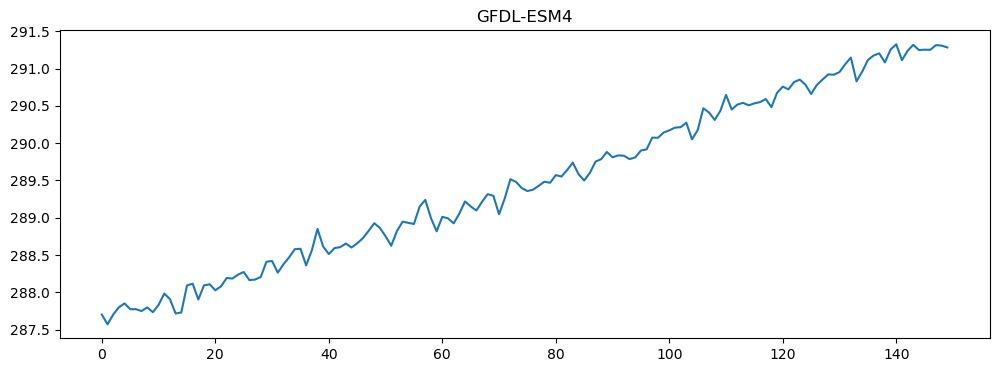

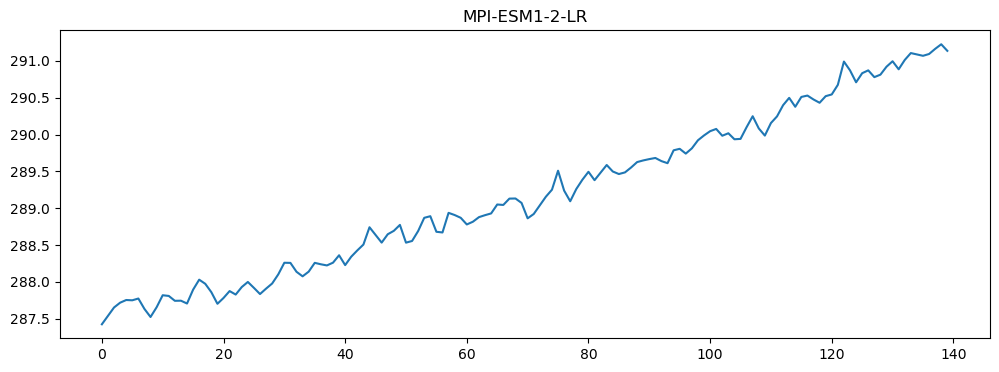

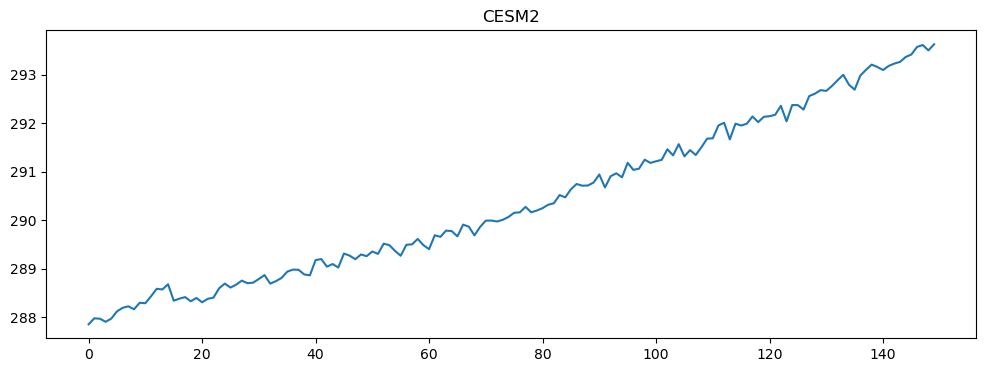

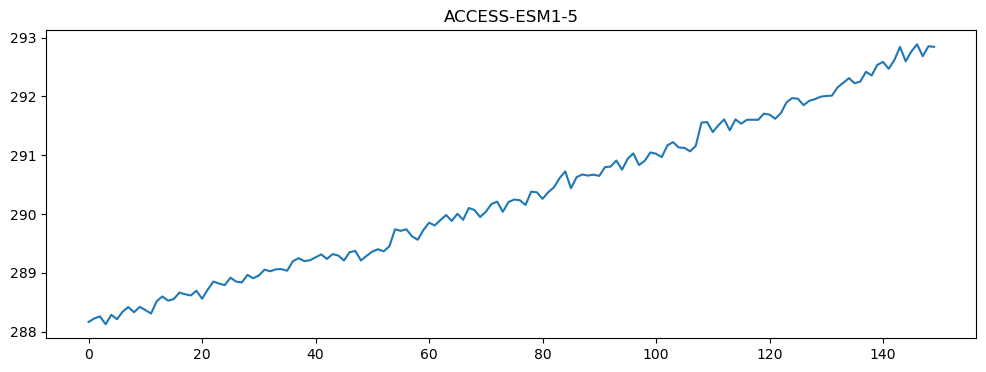

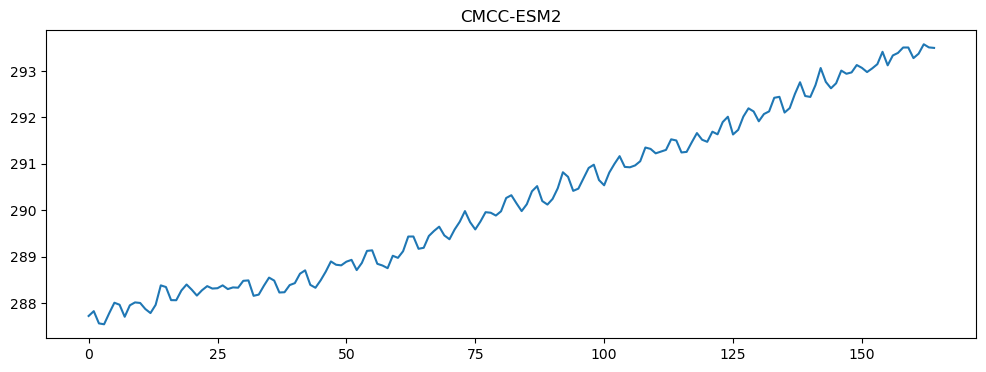

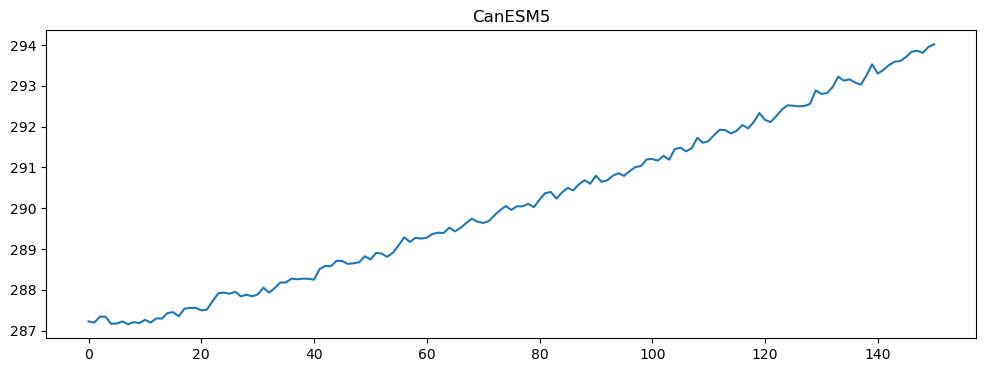

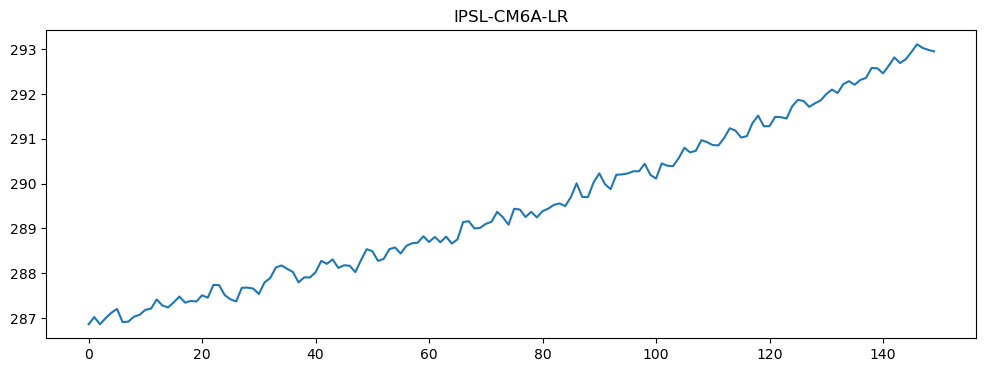

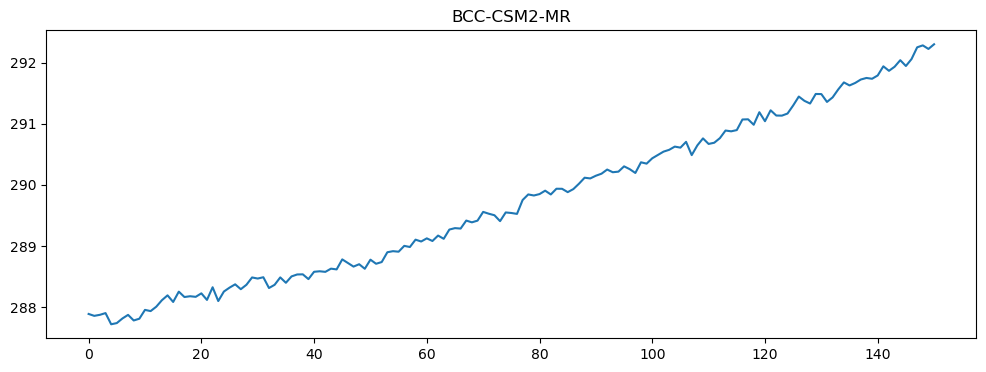

In [77]:
def timeseries(values, name=""):
    i = 0
    weights = cuts(values.shape[1],values.shape[2])

    plt.figure(figsize=(12,4))
    
    values = np.nan_to_num(values)
    monthly = np.sum(values * weights, axis=(1,2))
    yearly = np.mean(monthly.reshape(-1, 12), axis=1)
    
    plt.plot(yearly)
    plt.title(name)

for expname in list_experiments("ts"):
    timeseries(load("ts", expname), expname)

In [7]:
def vpd(ts, hurs):
    ts_c = ts - 273.15
    vpsat = 6.1094 * np.exp(17.625 * ts_c / (ts_c + 243.04)) # in hPa, from claus-clap wikipedia page
    #plt.imshow(vpsat)
    #plt.colorbar()

    vpd = (vpsat/10) * ((100-hurs)/100) # from vpd wikipedia page, unit shouldnt matter because scaler * percent?
    return vpd

GFDL-ESM4 (Temp. Precip. VPD) * [-6.3238516e-02  1.1526189e+05 -3.9062500e-01] + 18.081955
GFDL-ESM4 (Temp. Precip. VPD) R^2 Present 0.3790080754913505
GFDL-ESM4 (Temp. Precip. VPD) R^2 Future 0.35245449093435954
GFDL-ESM4 (Temp. Precip. VPD) * [ 2.5422342e-02  1.0371394e+05 -3.4921875e+00] + -5.086998
GFDL-ESM4 (Temp. Precip. VPD) R^2 Present 0.4252401482617899
GFDL-ESM4 (Temp. Precip. VPD) R^2 Future 0.40553472449448347
MPI-ESM1-2-LR (Temp. Precip. VPD) * [ 9.3894087e-02  2.1280438e+05 -2.9687500e-01] + -28.742676
MPI-ESM1-2-LR (Temp. Precip. VPD) R^2 Present 0.7608402909174056
MPI-ESM1-2-LR (Temp. Precip. VPD) R^2 Future 0.7655032165493852
MPI-ESM1-2-LR (Temp. Precip. VPD) * [ 7.3263548e-02  6.5206984e+04 -1.5937500e+00] + -19.393208
MPI-ESM1-2-LR (Temp. Precip. VPD) R^2 Present 0.2665565171162565
MPI-ESM1-2-LR (Temp. Precip. VPD) R^2 Future 0.24859221176584367


/usr/lib/python3.12/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'cVeg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/lib/python3.12/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'cVeg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/lib/python3.12/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'cVeg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/lib/python3.12/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/lib/python3.12/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = deco

CESM2 (Temp. Precip. VPD) * [ 2.79035807e-01  1.20283984e+05 -3.90625000e+00] + -77.07739
CESM2 (Temp. Precip. VPD) R^2 Present 0.6857127027188227
CESM2 (Temp. Precip. VPD) R^2 Future 0.6265069455913711
CESM2 (Temp. Precip. VPD) * [ 1.5914302e-01  7.5308961e+04 -6.0390625e+00] + -40.275738
CESM2 (Temp. Precip. VPD) R^2 Present 0.27001400238602147
CESM2 (Temp. Precip. VPD) R^2 Future 0.278127881113445


/usr/lib/python3.12/site-packages/xarray/coding/times.py:152: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/usr/lib/python3.12/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/lib/python3.12/site-packages/xarray/core/indexing.py:529: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/u

ACCESS-ESM1-5 (Temp. Precip. VPD) * [-2.2327864e-01  9.4513977e+04 -1.8828125e+00] + 70.24519
ACCESS-ESM1-5 (Temp. Precip. VPD) R^2 Present 0.5266850968969493
ACCESS-ESM1-5 (Temp. Precip. VPD) R^2 Future 0.4779794369808894
ACCESS-ESM1-5 (Temp. Precip. VPD) * [ 3.1602383e-01  4.1353918e+04 -1.0511719e+01] + -82.166306
ACCESS-ESM1-5 (Temp. Precip. VPD) R^2 Present 0.3498327569444283
ACCESS-ESM1-5 (Temp. Precip. VPD) R^2 Future 0.23138838687131746
CMCC-ESM2 (Temp. Precip. VPD) * [ 3.2540050e-01  7.4083367e+04 -5.6015625e+00] + -88.823616
CMCC-ESM2 (Temp. Precip. VPD) R^2 Present 0.4709344866965489
CMCC-ESM2 (Temp. Precip. VPD) R^2 Future 0.45488874509973953
CMCC-ESM2 (Temp. Precip. VPD) * [ 8.5088126e-02  8.5313148e+04 -2.8359375e+00] + -22.232277
CMCC-ESM2 (Temp. Precip. VPD) R^2 Present 0.30233971277008076
CMCC-ESM2 (Temp. Precip. VPD) R^2 Future 0.2801675446952293
CanESM5 (Temp. Precip. VPD) * [ 6.9006100e-02  8.1873078e+04 -2.3046875e+00] + -16.393639
CanESM5 (Temp. Precip. VPD) R^2 P

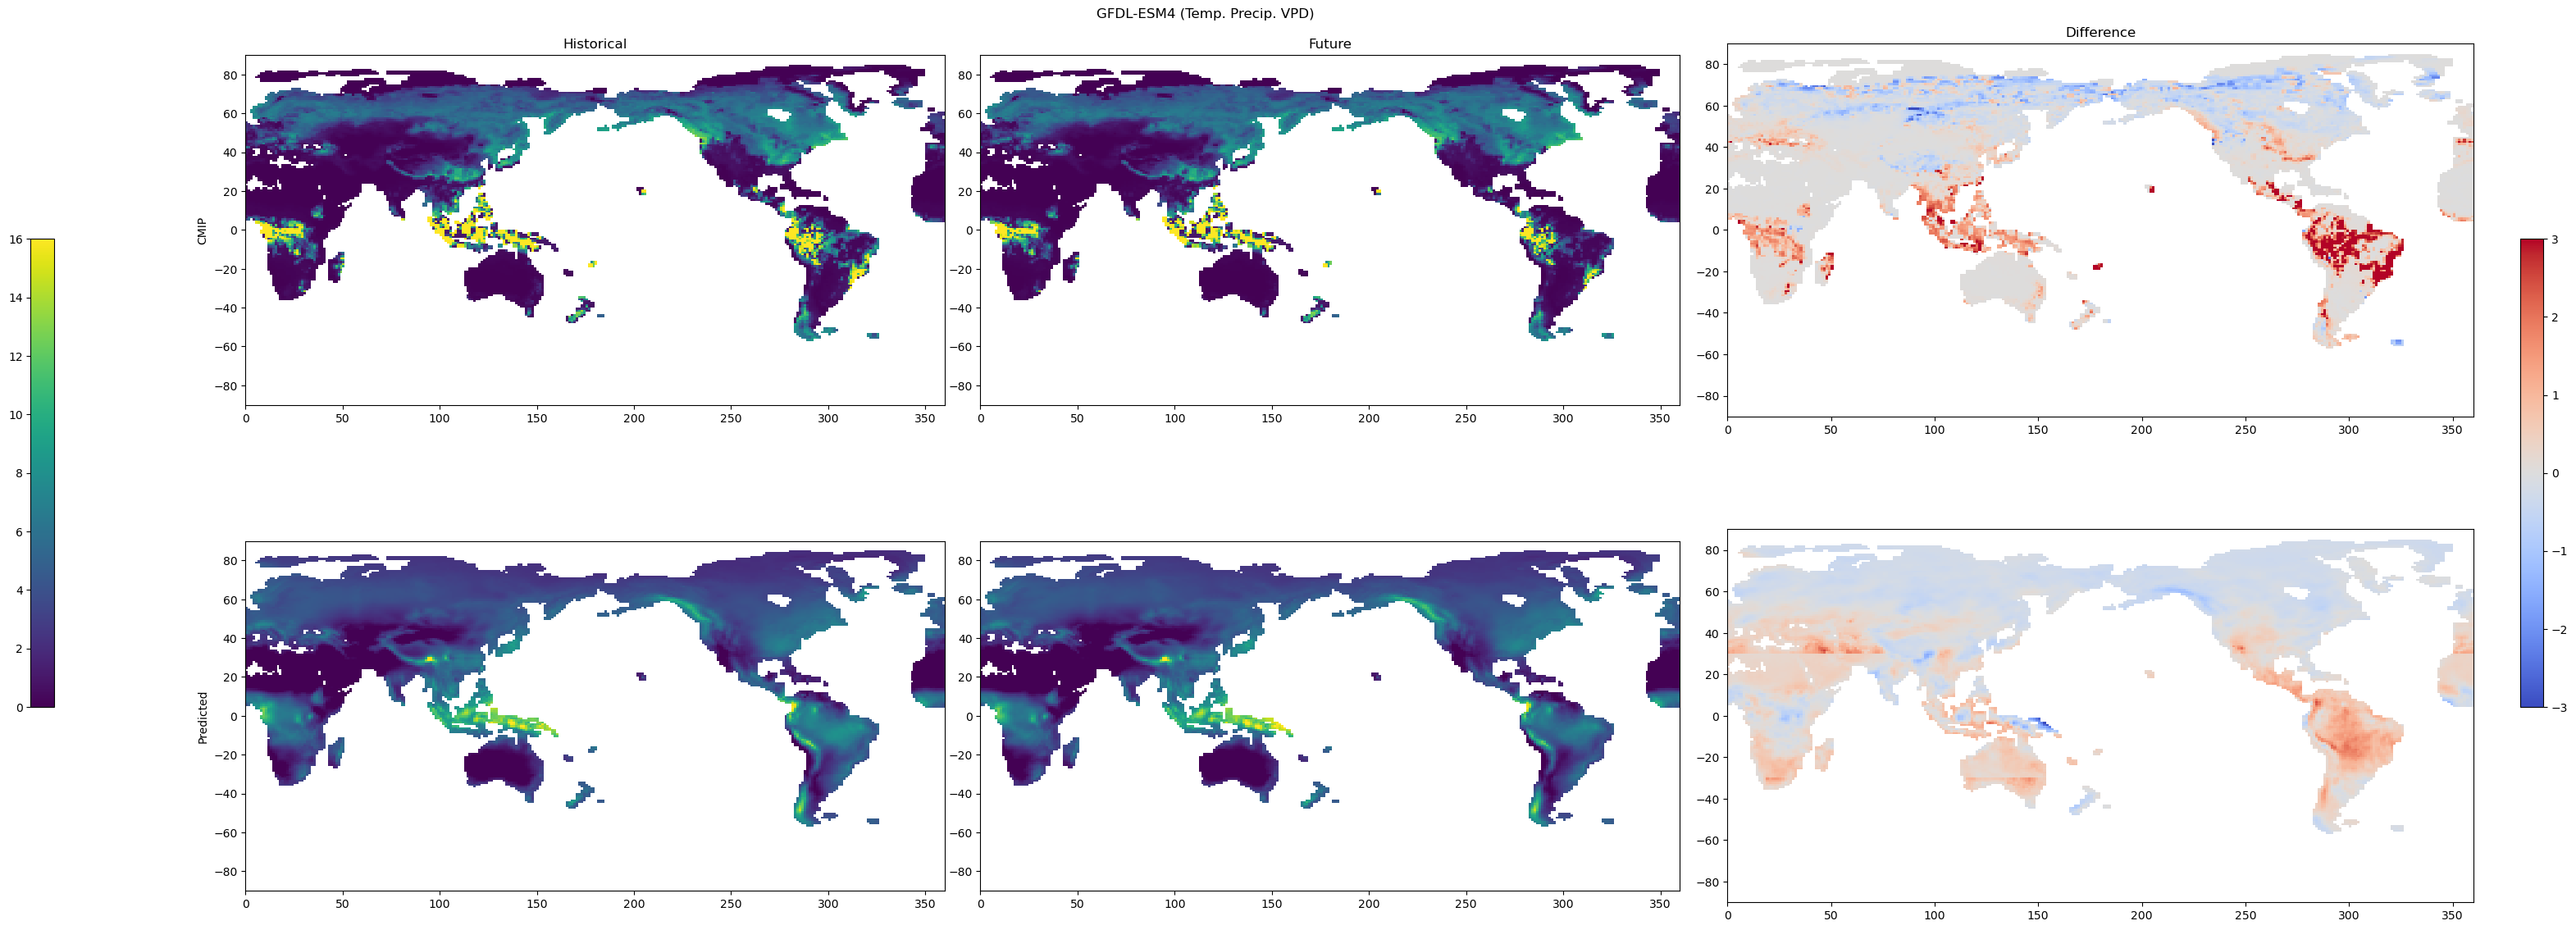

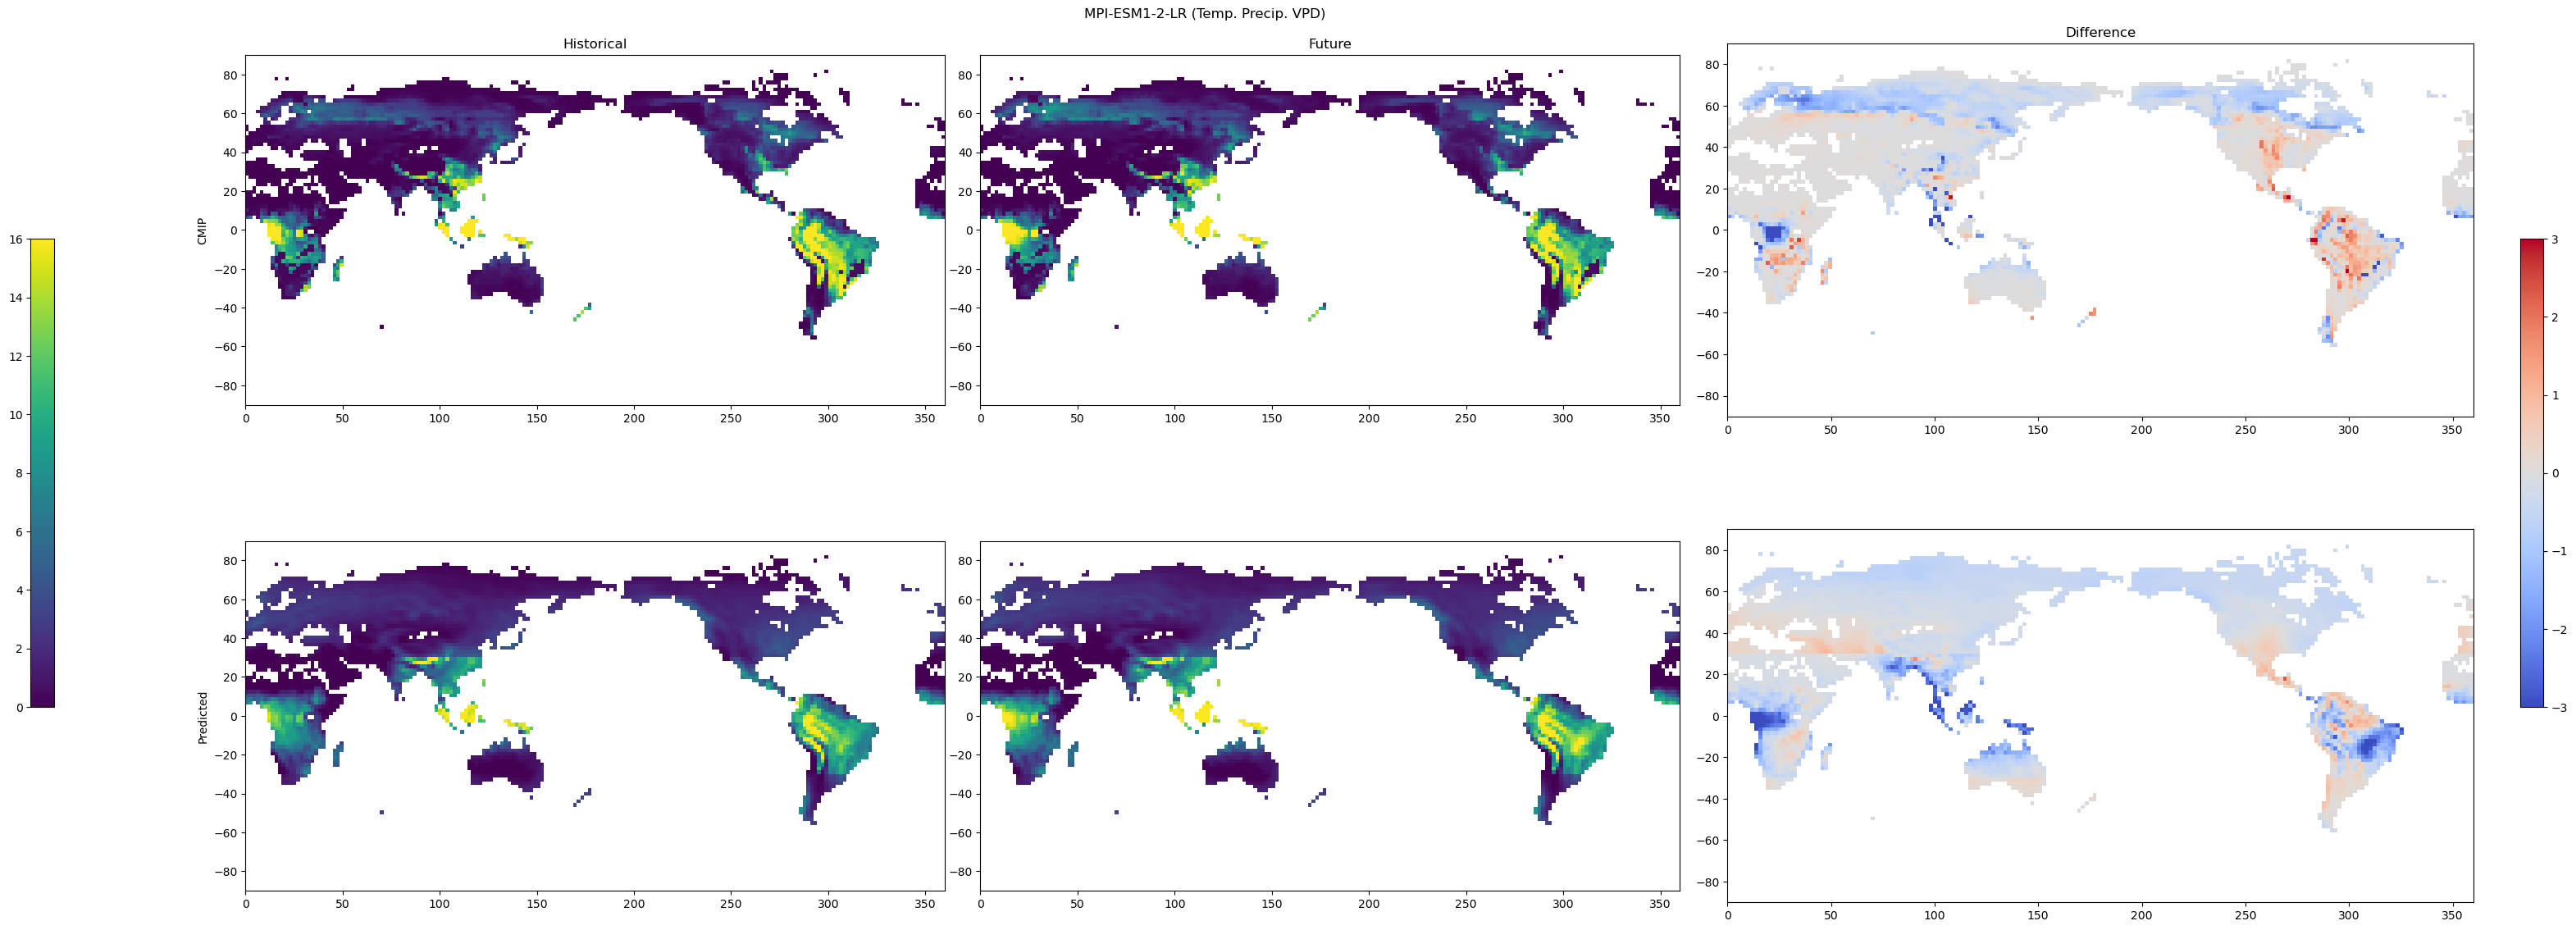

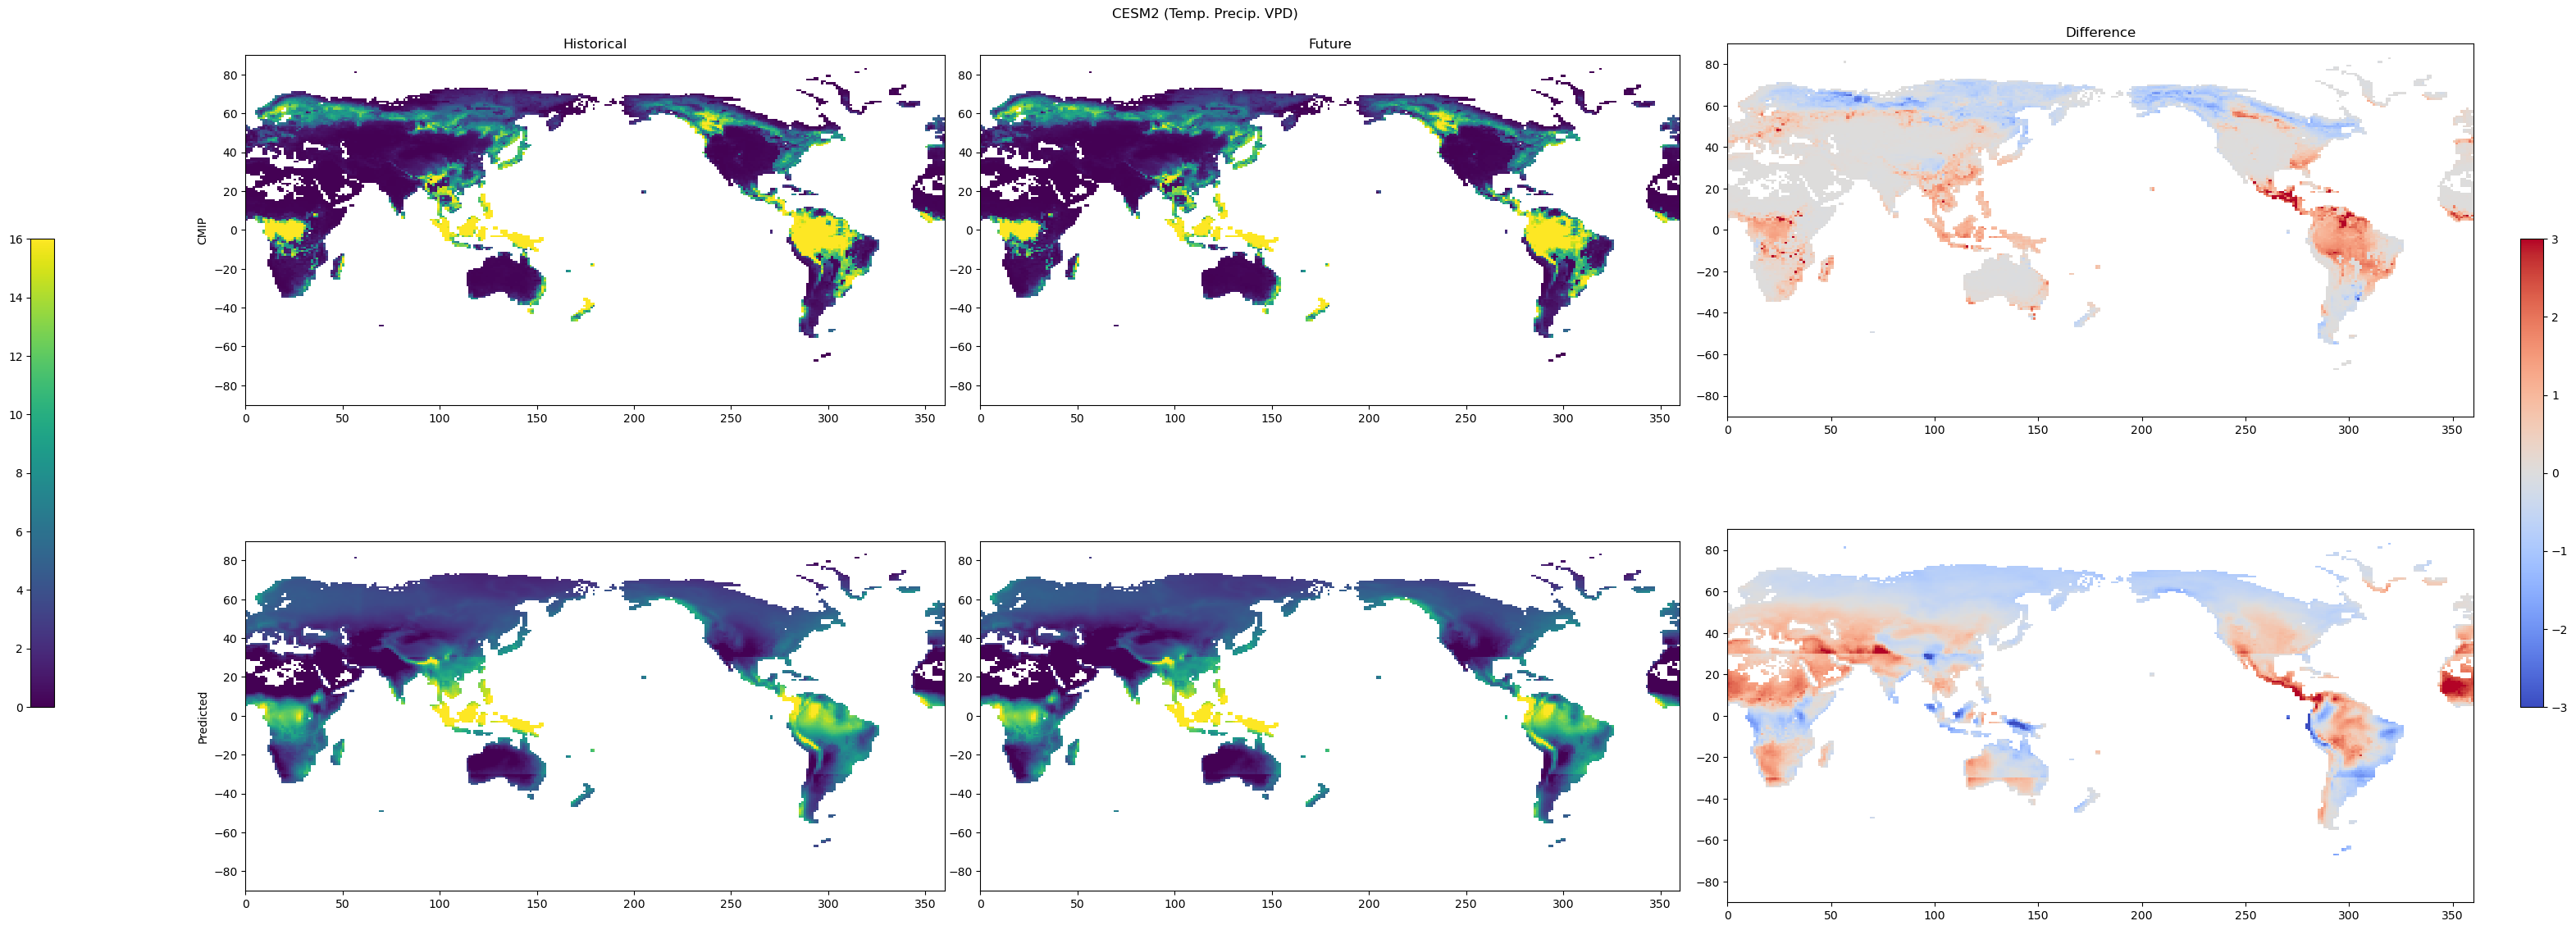

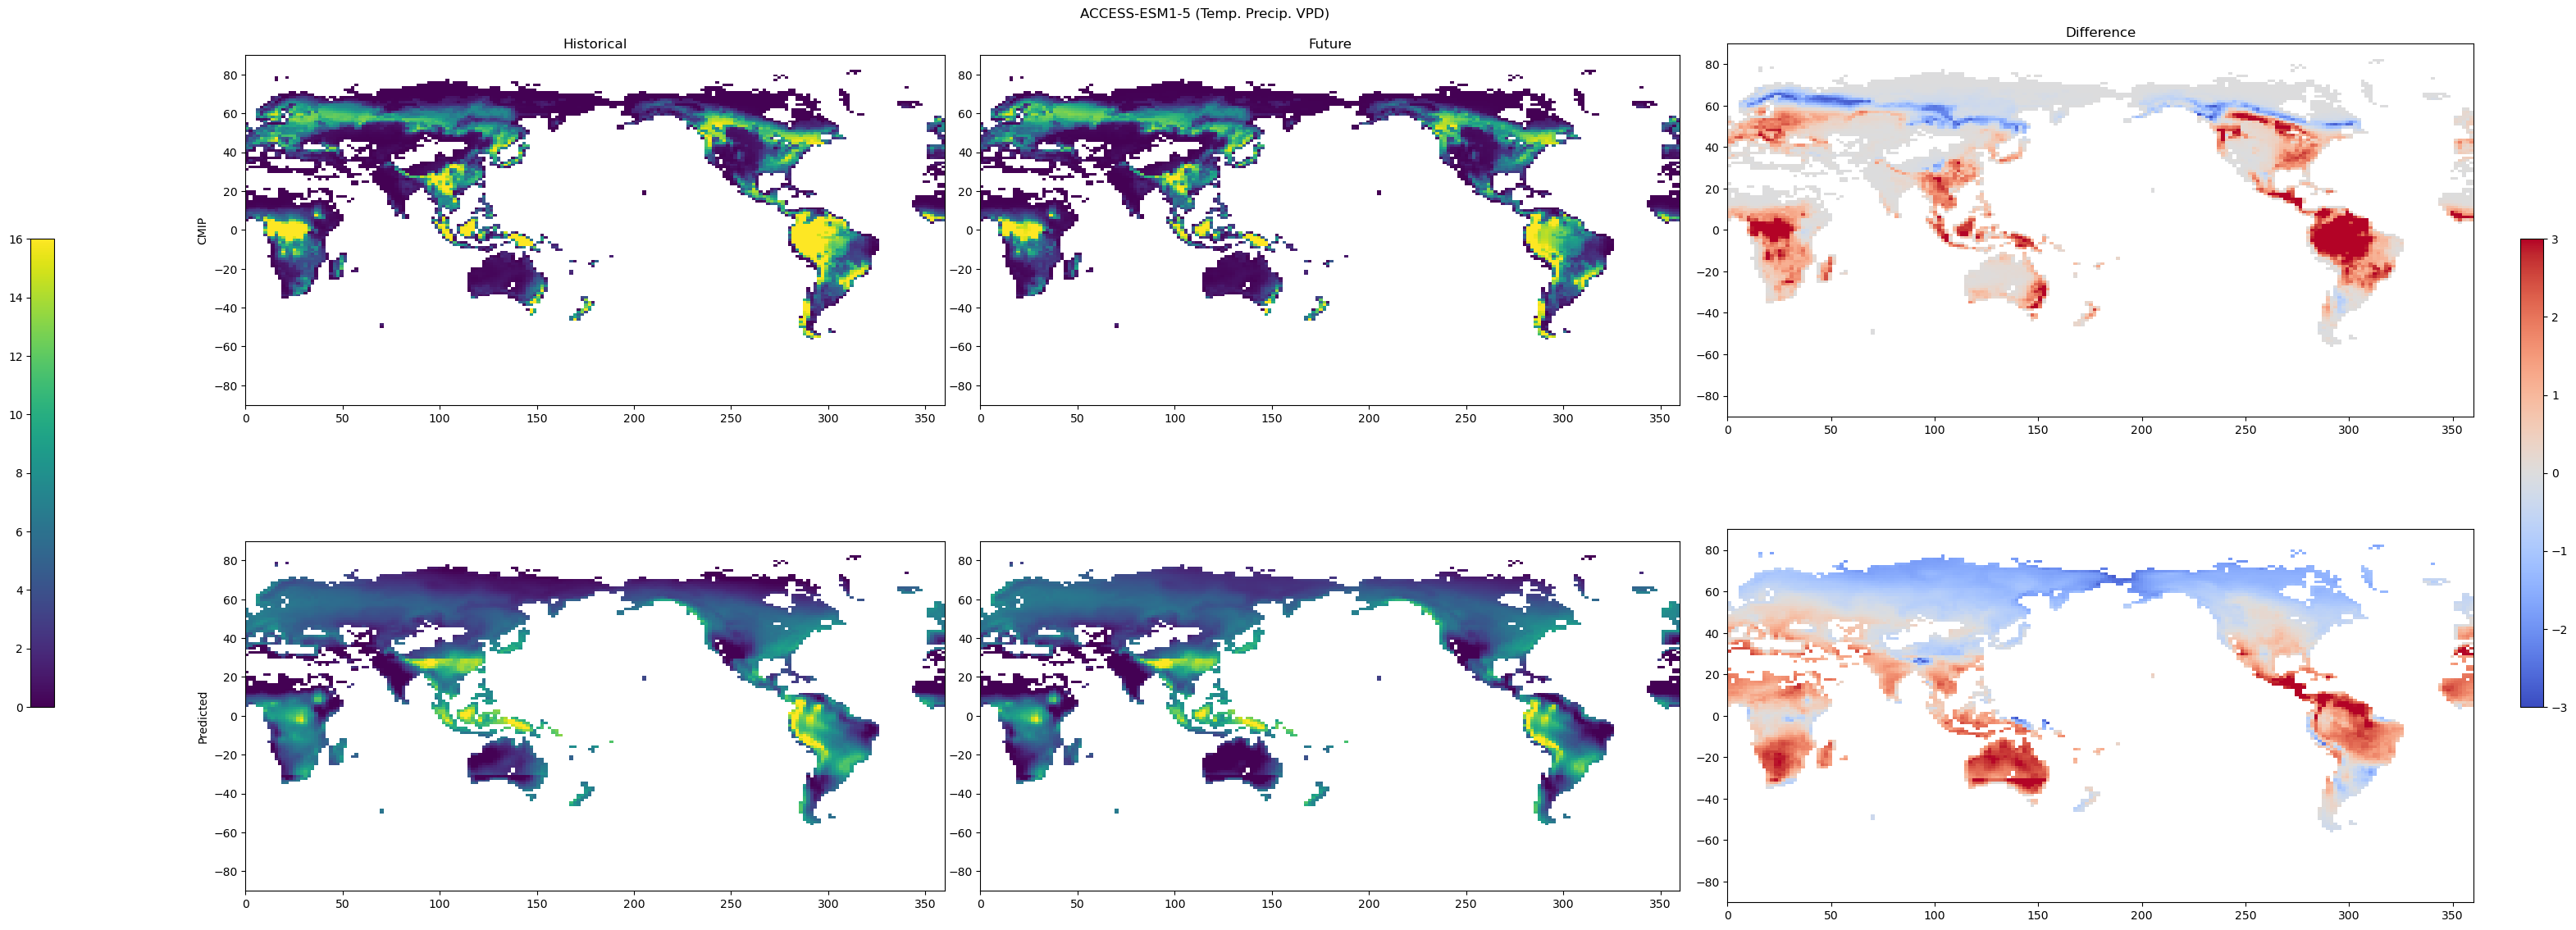

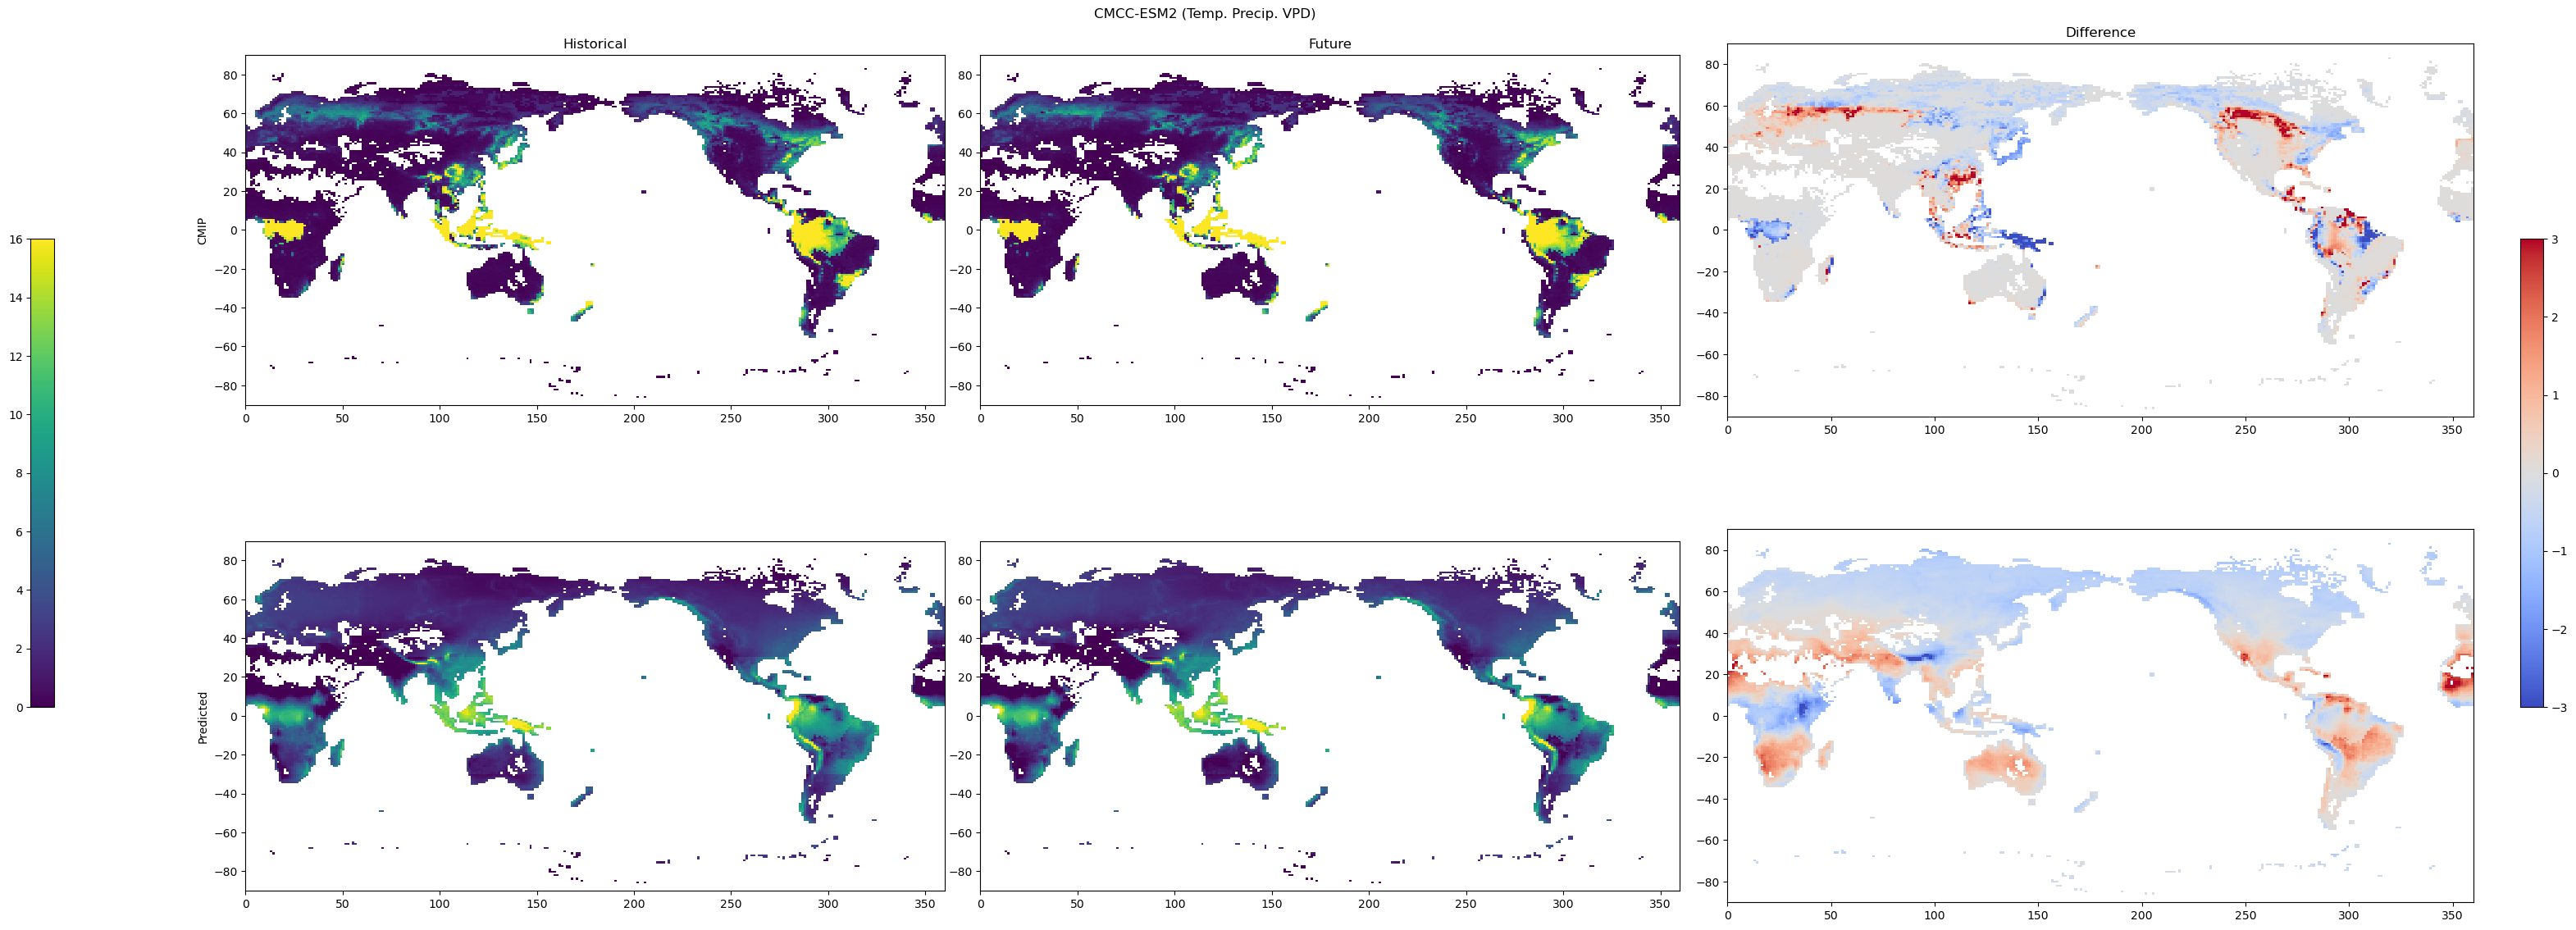

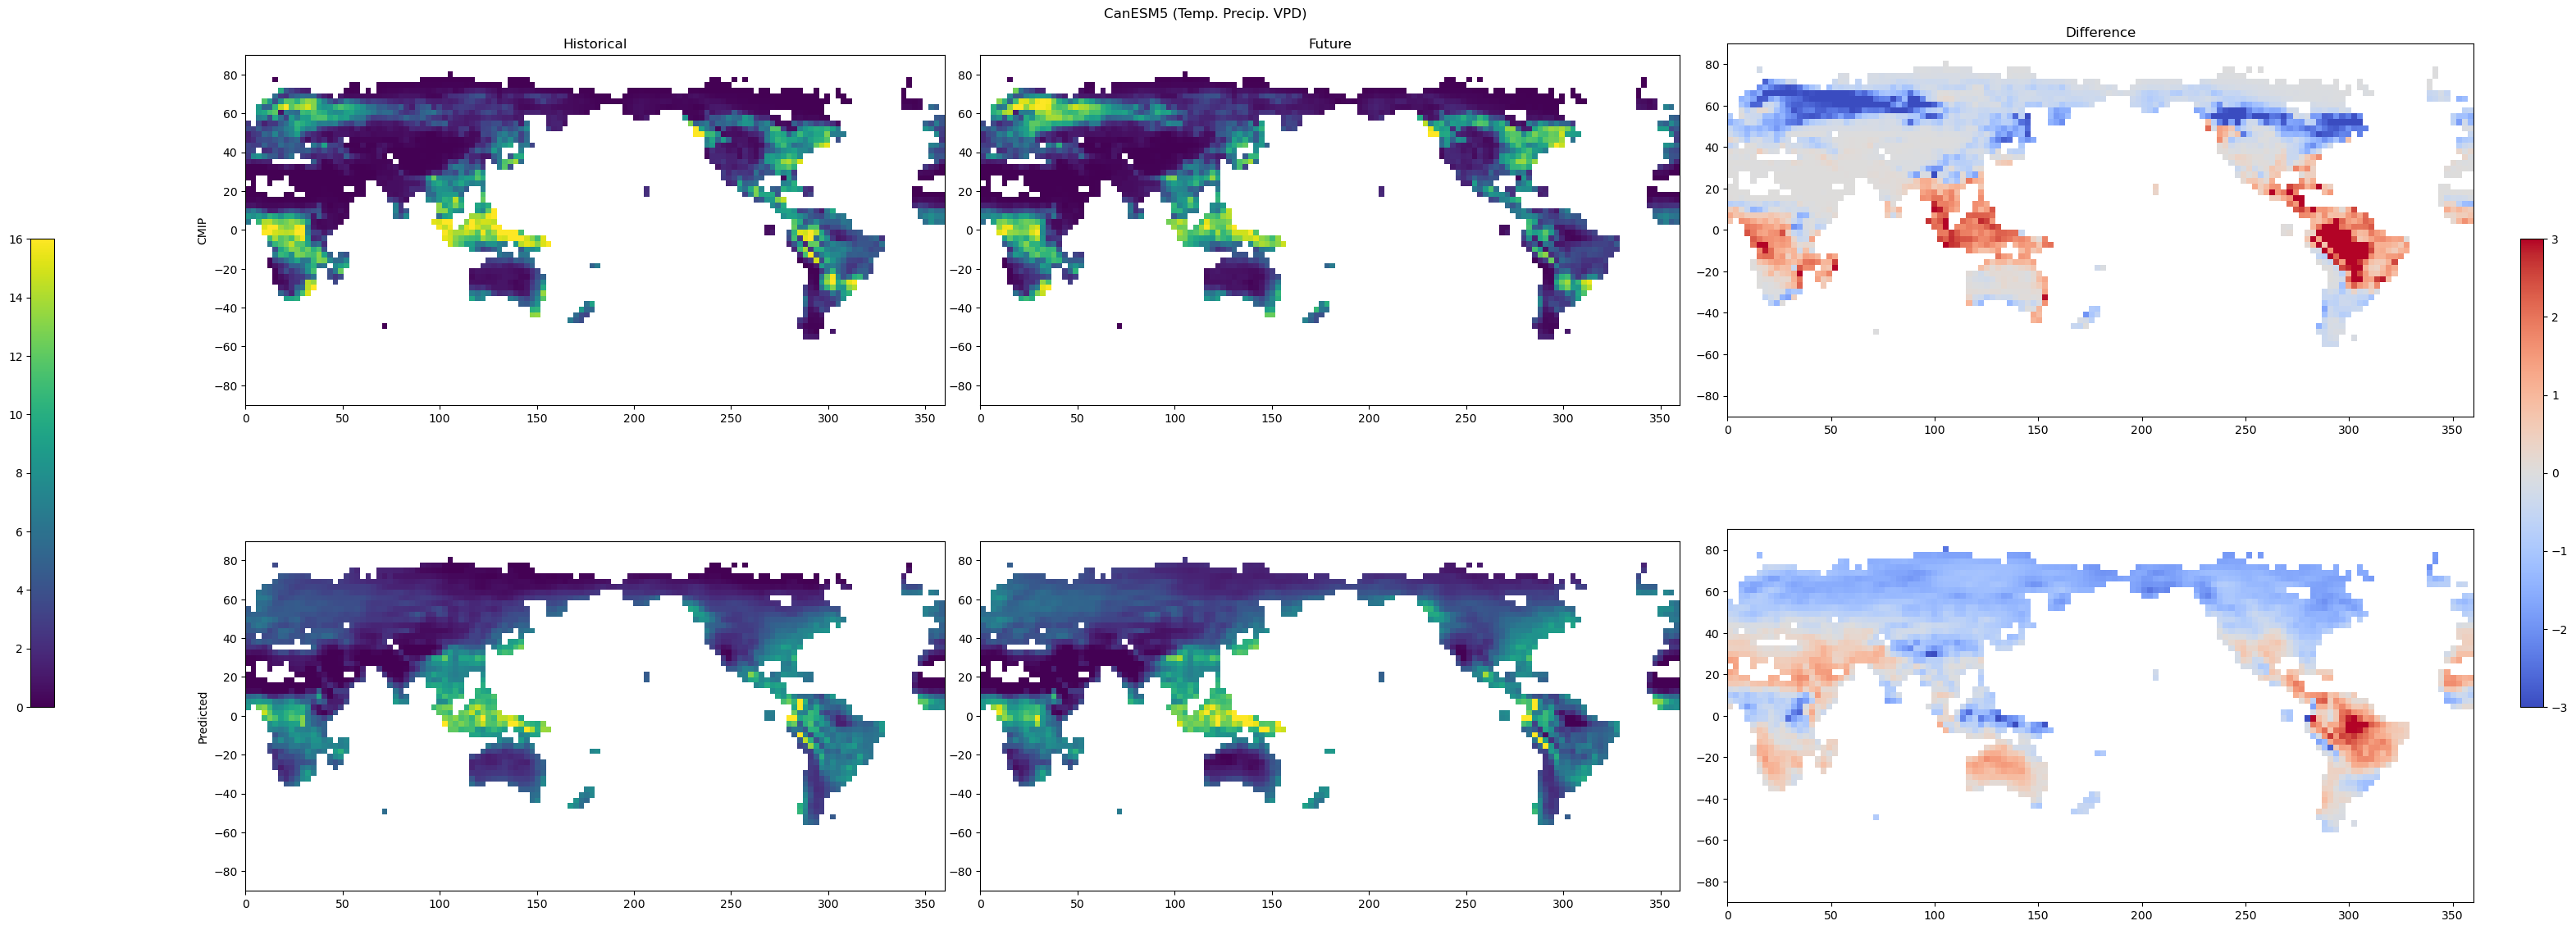

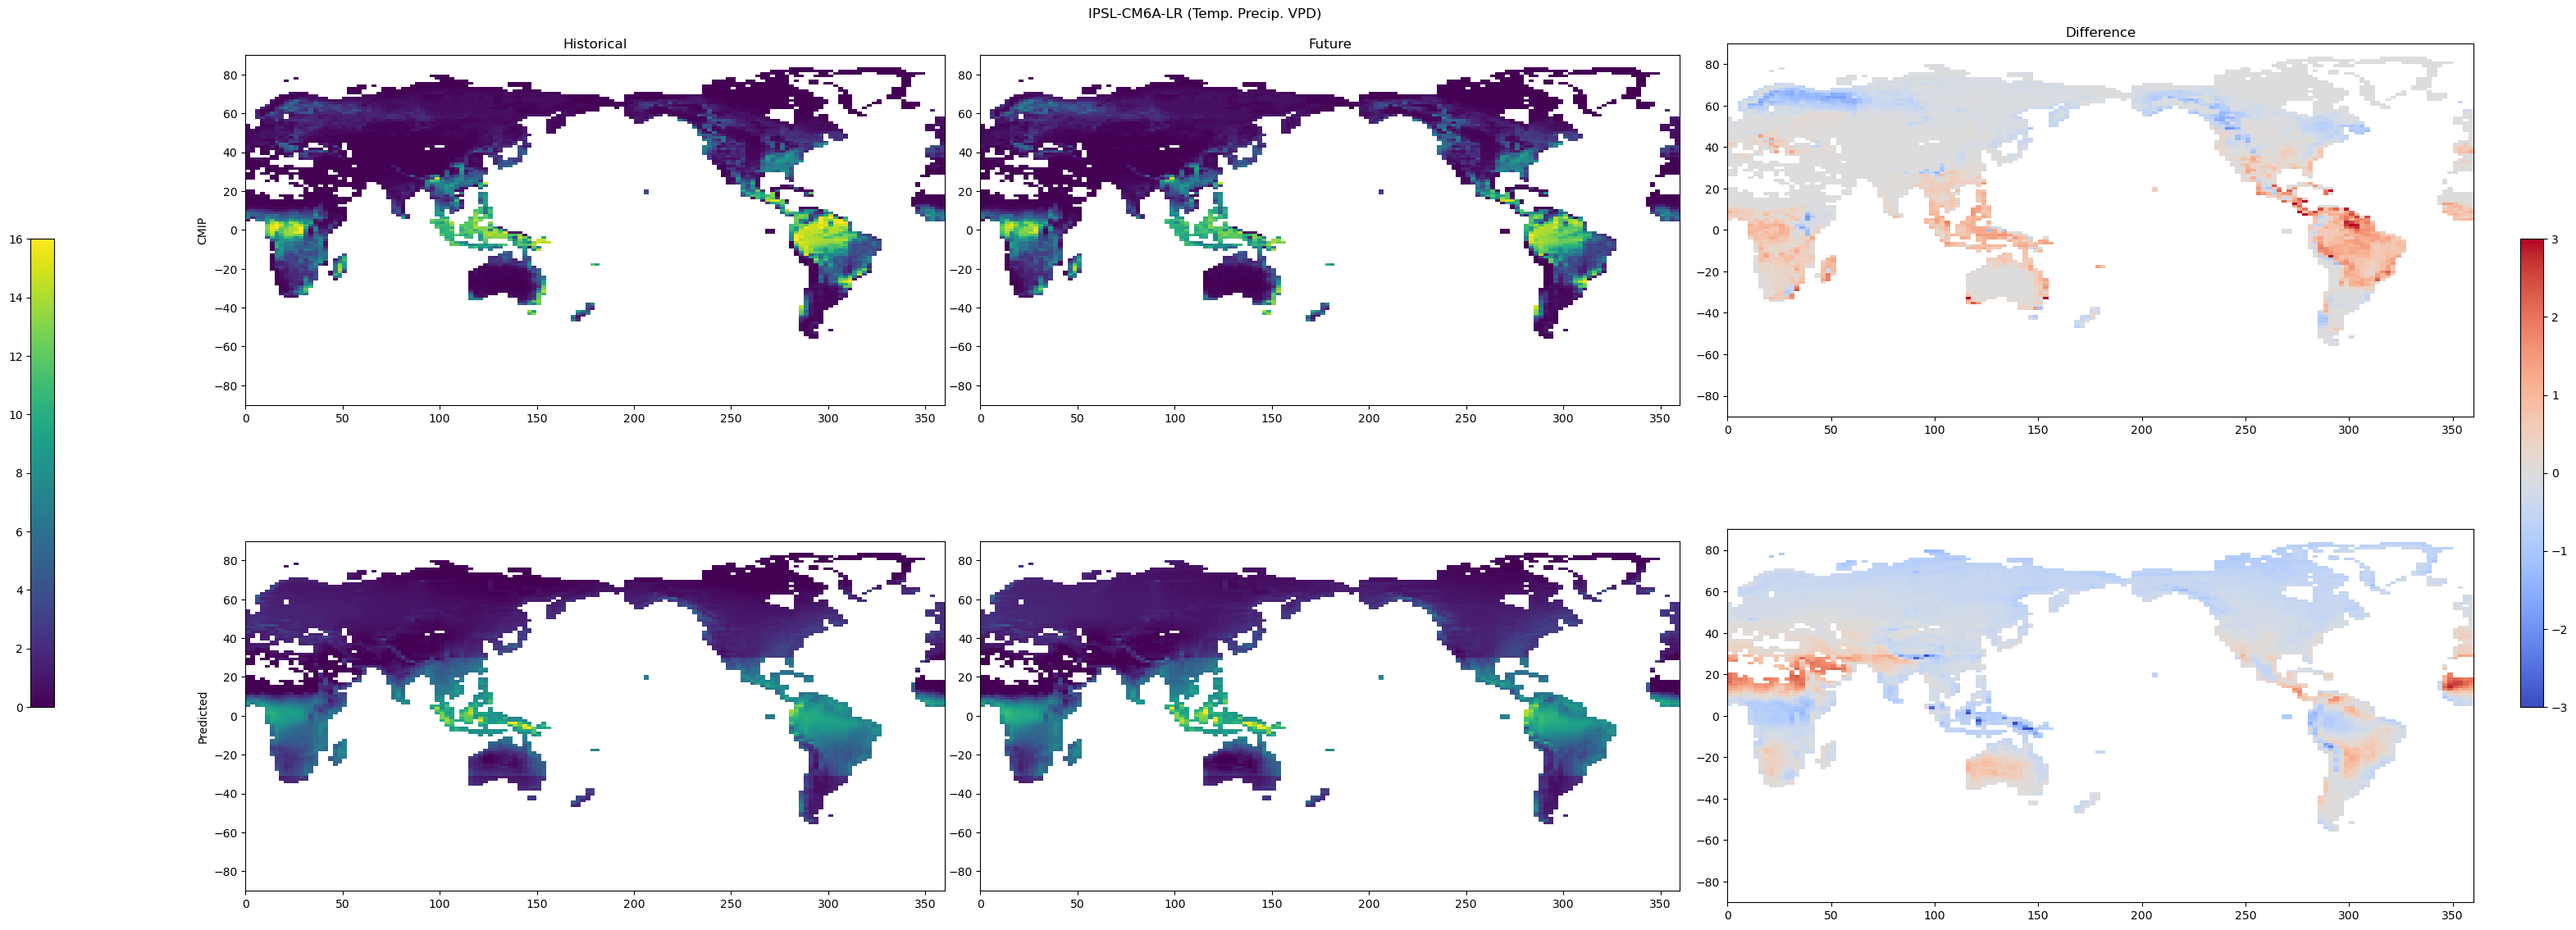

In [82]:
i = 0
for expname in list_experiments("hurs"):
    cveg_data = load("cVeg", expname)
    pr_data = load("pr", expname)
    ts_data = load("ts", expname)
    hurs_data = load("hurs", expname)
    
    x_cveg = avg20(cveg_data[start_x:end_x,:,:])
    x_ts = avg20(ts_data[start_x:end_x,:,:])
    x_pr = avg20(pr_data[start_x:end_x,:,:])
    x_hurs = avg20(hurs_data[start_x:end_x,:,:])
    #x_gpp = avg20(gpp_data[start_x:end_x,:,:])
    y_ts = avg20(ts_data[start_y:end_y,:,:])
    y_pr = avg20(pr_data[start_y:end_y,:,:])
    y_hurs = avg20(hurs_data[start_y:end_y,:,:])
    #y_gpp = avg20(gpp_data[start_y:end_y,:,:])
    y_cveg = avg20(cveg_data[start_y:end_y,:,:])

    x_vpd = vpd(x_ts, x_hurs)
    y_vpd = vpd(y_ts, y_hurs)

    #plt.figure(i)
    #plt.imshow(x_vpd[::-1], vmin=0, vmax=2.5)
    #plt.colorbar()
    #plt.title("VPD " + expname)
    #plt.savefig("figure_vpd_" + expname + ".png")
    #i += 1

    tropics = np.full([x_cveg.shape[0],x_cveg.shape[1]], False)
    tropics[x_cveg.shape[0]//3:2*x_cveg.shape[0]//3,:] = True

    mask1 = (x_cveg > 0) & tropics
    mask2 = (x_cveg > 0) & ~tropics

    #plt.figure(i)
    #plt.imshow((y_cveg - x_cveg)[::-1], vmin=-2.5, vmax=2.5, cmap="coolwarm")
    #plt.colorbar()
    #plt.savefig("figure_delta50_" + expname + ".png")
    #i += 1
    
    fit_and_test(np.array([x_ts, x_pr, x_vpd]), x_cveg, [mask1,mask2], np.array([y_ts, y_pr, y_vpd]), y_cveg, expname + " (Temp. Precip. VPD)")
    